In [1]:
import sys
!{sys.executable} -m pip install matplotlib
!{sys.executable} -m pip install numpy
!{sys.executable} -m pip install pandas
!{sys.executable} -m pip install seaborn
!{sys.executable} -m pip install imblearn
!{sys.executable} -m pip install scikit-learn

In [2]:
# *********************************************************************************************************************
# Import Statement
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
import time
import zipfile
from datetime import datetime
from file_handling import *
from imblearn.over_sampling import SMOTE
from selection import *
from sklearn import metrics
from sklearn import tree
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import *
from sklearn.tree import DecisionTreeRegressor
# *********************************************************************************************************************

In [3]:
# *********************************************************************************************************************
# Import Data
# Assign data in folder
in_flder = "data_in"

# Unzip files
with zipfile.ZipFile(os.path.join(in_flder, 'census_income_learn.zip'), 'r') as zip_ref:
    zip_ref.extractall(in_flder)
with zipfile.ZipFile(os.path.join(in_flder, 'census_income_test.zip'), 'r') as zip_ref:
    zip_ref.extractall(in_flder)

# Import csv's
data_train = open_unknown_csv(os.path.join(in_flder, 'census_income_learn.csv'), ',')
data_test = open_unknown_csv(os.path.join(in_flder, 'census_income_test.csv'), ',')
# *********************************************************************************************************************

Opened file using encoder: utf_8
Opened file using encoder: utf_8


In [4]:
# Assign output folder
out_fldr = "data_out"

At this point, I realized that the csv's don't have a header.
The metadata text file doesn't perfectly match with the dataset in the column headers as there are 41
(excluding target) columns in the data and 46 columns listed.<br />

This threw me off for quite a while as I was looking at the first column name list. I started to go through column
by column and try to use domain knowledge to determine if the column names made sense.
Additionally, I even created this quick check to compare the number of distinct values in each column to the basic
statistics list lower in the metadata table.

In [5]:
# For every column, get a count distinct to identify the column names.
for columnname, i in data_train.iteritems():
    print(str(data_train.columns.get_loc(columnname)) + ": " + str(len(unique(i))))

0: 91
1: 9
2: 52
3: 47
4: 17
5: 1240
6: 3
7: 7
8: 24
9: 15
10: 5
11: 10
12: 2
13: 3
14: 6
15: 8
16: 132
17: 113
18: 1478
19: 6
20: 6
21: 51
22: 38
23: 8
24: 99800
25: 10
26: 9
27: 10
28: 3
29: 4
30: 7
31: 5
32: 43
33: 43
34: 43
35: 5
36: 3
37: 3
38: 3
39: 53
40: 2
41: 2


In [6]:
# *********************************************************************************************************************
# Import Data - Attempt 2
# Import data without header set to row 0
data_train = open_unknown_csv(os.path.join(in_flder, 'census_income_learn.csv'), ',', header=None)
data_test = open_unknown_csv(os.path.join(in_flder, 'census_income_test.csv'), ',', header=None)

# After column sanity check, create header list from metadata document.
# Note: Column 24 has 99800 distinct values and wasn't explained in the metadata file.
header_list = ['age', 'class of worker', 'detailed industry recode', 'detailed occupation recode', 'education',
               'wage per hour', 'enroll in edu inst last wk', 'marital stat', 'major industry code',
               'major occupation code', 'race', 'hispanic origin', 'sex', 'member of a labor union',
               'reason for unemployment', 'full or part time employment stat', 'capital gains', 'capital losses',
               'dividends from stocks', 'tax filer stat', 'region of previous residence', 'state of previous residence',
               'detailed household and family stat', 'detailed household summary in household', 'Unknown 1',
               'migration code-change in msa', 'migration code-change in reg', 'migration code-move within reg',
               'live in this house 1 year ago', 'migration prev res in sunbelt', 'num persons worked for employer',
               'family members under 18', 'country of birth father', 'country of birth mother', 'country of birth self',
               'citizenship', 'own business or self employed', "fill inc questionnaire for veteran's admin",
               'veterans benefits', 'weeks worked in year', 'year', 'under_50k']

# Add header to dataframe
data_train.columns = header_list
data_test.columns = header_list
# *********************************************************************************************************************

Opened file using encoder: utf_8
Opened file using encoder: utf_8


In [7]:
# *********************************************************************************************************************
# Data Wrangling and Cleaning
# Combine the two tables together, with a tag for what partition they are from.
# I combined them back together so I only need to encode once.
data_train["partition"] = "Train"
data_test["partition"] = "Test"
data = data_train.append(data_test)

# Get list of columns
columns = list(data)

# Get the dependent variable and remove from list
y_name = columns[41]
columns.remove(y_name)

# Get list of categorical variables and remove from list
categorical_list_name = list()
for i in columns:
    if data[i].dtype == "object":
        categorical_list_name.append(i)
for i in categorical_list_name:
    columns.remove(i)

# Some columns should be categorical instead of numerical even though they are numbers.
# These columns are 'detailed industry recode', 'detailed occupation recode', 'own business or self employed',
# 'veterans benefits'
for i in ['detailed industry recode', 'detailed occupation recode', 'own business or self employed',
          'veterans benefits']:
    categorical_list_name.append(i)
    columns.remove(i)

# Exclude partition column from categorical list name as it isn't an independent variable
categorical_list_name.remove("partition")

# Since no boolean values exists, the rest of the variables are numeric
numeric_list_name = columns

# Convert target to boolean
data[pd.get_dummies(data[y_name], prefix='Target').columns[1]] = pd.get_dummies(data[y_name], prefix='Target')[
    pd.get_dummies(data[y_name], prefix='Target').columns[1]]

# Remove old target column and rename y_name
y_name_old = y_name
y_name = pd.get_dummies(data[y_name_old], prefix='Target').columns[1]
data = data.drop(columns=y_name_old)
# *********************************************************************************************************************

C:\Users\david.liau\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:11: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  # This is added back by InteractiveShellApp.init_path()


<Figure size 432x288 with 0 Axes>

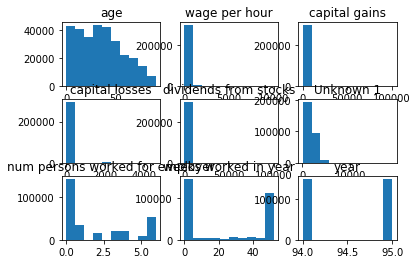

[Text(0.5, 0, 'age'),
 Text(1.5, 0, 'wage per hour'),
 Text(2.5, 0, 'capital gains'),
 Text(3.5, 0, 'capital losses'),
 Text(4.5, 0, 'dividends from stocks'),
 Text(5.5, 0, 'Unknown 1'),
 Text(6.5, 0, 'num persons worked for employer'),
 Text(7.5, 0, 'weeks worked in year'),
 Text(8.5, 0, 'year')]

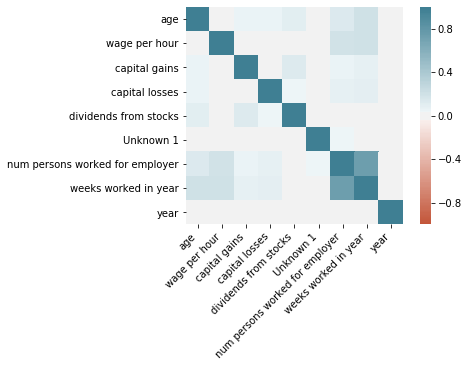

In [8]:
# *********************************************************************************************************************
# Data Exploration
# Create new dataframe for descriptive statistics
descriptive_categorical = pd.DataFrame()

# Perform descriptive statistics on numeric columns
descriptive_numeric = data.describe()

# Include Missing Value calculation
descriptive_numeric = pd.concat([descriptive_numeric,
                                 data[numeric_list_name].isnull().sum().to_frame(name='missing').T])
descriptive_categorical = pd.concat([descriptive_categorical,
                                     data[categorical_list_name].isnull().sum().to_frame(name='missing').T])

# Create Histogram of all numeric columns to see if they are normally distributed
plt.figure(1)
fig, axs = plt.subplots(3, 3)
column_index = 0
axs = axs.ravel()
for idx, ax in enumerate(axs):
    if idx <= len(numeric_list_name) - 1:
        ax.hist(data[numeric_list_name[idx]])
        ax.set_title(numeric_list_name[idx])
plt.show()

# Create a correlation heatmap of numeric values
corr = data[numeric_list_name].corr()
plt.figure(2)
ax = sns.heatmap(
    corr,
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
)

# Complete correlation matrix will be created after one-hot encoding to include categorical variables.
# *********************************************************************************************************************

# Findings from data exploration. #

*Multi-collinearity*: Among the numeric columns some multi-collinearity does exists. This highly correlated data points
align with domain expectations, such as people working at companies with more employees, tend to get paid more and
work more hours.

Since the data is complete now, i am going to complete a data audit. While it is possible to do this in python,
I really wouldn't do it using python/matplotlib in practice due to how good Tableau is at looking at data.

In [9]:
#Export train data to csv for Tableau viewing.
data.to_csv(os.path.join(out_fldr, "data_train.csv"), index=False)

In [10]:
# *********************************************************************************************************************
# One hot encode for each of the categorical datasets
for i in categorical_list_name:
    # Dummy encode variables
    data_dummies = pd.get_dummies(data[i], prefix=str(i))

    # From the created dummies, see which column, by index has the least values and remove to prevent multi-collinearity
    col_mean = 1
    lowest_col = 0
    for index, j in enumerate(data_dummies.mean()):
        if j < col_mean:
            lowest_col = index
            col_mean = j

    # Drop index with smallest dummy amount
    data_dummies.drop(data_dummies.columns[lowest_col], axis=1, inplace=True)

    # Merge dummies with original data
    data = pd.concat([data, data_dummies], axis='columns')

    # Drop original column
    data = data.drop(i, axis=1)
# *********************************************************************************************************************

In [11]:
# *********************************************************************************************************************
# Data Exploration 2
# Create a correlation matrix of all columns
corr = data.corr().unstack().reset_index()

# Drop diagonal from correlation
corr = corr[corr['level_0'] != corr['level_1']]

# Reset index
corr.reset_index(drop=True, inplace=True)

# Sense many columns are one hot encoded, I will drop the correlations that are from the same original column because
# the correlations are always strong between them.
row_deletion = list()
for i in range(len(corr)):
    row_deletion_hold = 0

    # If '_' exists in column name
    underscore_location_0 = corr.loc[i, 'level_0'].find('_')
    underscore_location_1 = corr.loc[i, 'level_1'].find('_')
    if underscore_location_0 != -1:
        if underscore_location_1 != -1:
            if corr.loc[i, 'level_0'][:underscore_location_0] == corr.loc[i, 'level_1'][:underscore_location_1]:
                row_deletion_hold = 1
    row_deletion.append(row_deletion_hold)

# Add row deletion column
corr['row_deletion'] = row_deletion

# Delete Rows from Row Deletion Column and delete column
corr = corr[corr['row_deletion'] != 1]
corr.drop(columns='row_deletion', inplace=True)

# Reset index
corr.reset_index(drop=True, inplace=True)

# Sort by absolute value
corr['corr_abs'] = corr[0].abs()
corr = corr.sort_values(by='corr_abs', ascending=False)

# Drop correlations under 0.5
corr = corr[corr['corr_abs'] >= 0.5]
corr.drop(columns='corr_abs', inplace=True)

# Make correlation matrix
corr_matrix = corr.pivot(index='level_0', columns='level_1', values=0)

# Plot correlation matrix
plt.figure(3)
ax = sns.heatmap(
    corr_matrix,
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
)

# *********************************************************************************************************************

KeyboardInterrupt: 

# Analysis of Data Exploration 2. #

Looking at the complete correlation matrix, obvious patterns emerge with strong
correlations. The first being the strong relationship between the parents place of birth. The data suggests that
people tend to get married to each of from their same birth country. Secondly, two columns that are highly related
to each other are the migration columns. There are two migration codes, and it would make sense that they are
interdependent. There is additional relationships between moving/migration and whether or not someone lived in the
same house 1 year ago. Small other correlations exists such a negative correlation between being single and a
child's education.<br />

While some of these correlations are of concern, I don't believe for the purposes of this example
that anything needs to be done about them. The models being used will use a greedy algorithm and preferentially split
based on highest gain, possibly leading to insights such as, the mother's country of origin is the most important
factor for income, while causally it is actually the father's country of origin is the most important factor, as an
example. In this example, I don't think that the overall impact to the insight's or the models predictive capability
would be hindered too much as these correlations make a ton of intuitive sense. For a more robust model, I would
use a PCA and reduce the dimensionality prior to modeling, taking care of this highly correlated values.
Note: I did filter down to correlations of greater than |0.5|. I prefer to put that setting to 0.2, but it becomes
hard to see with the number of factors that gets through. In real work, I would export the correlation matrix
to Tableau for visualization, instead of using python.

*********************************************************************************************************************
### Normalize Values ###
Normally, I would Normalize the independent variables at this step as it tends to yield better results, but since I
will be mostly using decision tree based models, it isn't as necessary since the models are non-parametric.
*********************************************************************************************************************

### Remove/Impute Outliers ###
Similarly to normalizing values, I would normally impute or remove outliers prior to modeling, however, since I am
focusing mostly on the decision tree based models, outliers tend to have a negligible on decision tee models due to
the methods that they perform splits (splits are typically conducted on population proportion instead of values).
*********************************************************************************************************************

### Missing Value Handling ###
There is no missing values in the dataset. If there was, there are several ways for me to handle missing data
including data imputation using mean, mode, monte carlo sampling, clustering. If interested, ask me about missing
Data handling as it was a focus of mine during my second masters program.

*Note*: in this case, I would consider just accepting the missing data.

*Note 2*: Technically, records with the value of "Not in Universe" or ? are the equivalent of missing values and may
benefit from using a missing value imputation technique, such as clustering the drawing from each cluster. For a
bigger project, I would attempt this missing value imputation, but given the amount of missing values, I do not
believe that it would be too effective and would lead to over-fitting.
*********************************************************************************************************************

In [ ]:
# Feature Creation
data.loc[data['capital gains'] > 0, 'Any Capital Gains'] = 1
data.loc[data['capital gains'] == 0, 'Any Capital Gains'] = 0

In [ ]:
# *********************************************************************************************************************
# Partition Data
# Separate data into X and y for train partition
X_train = data[data["partition"] == "Train"].drop(columns=[y_name, "partition"], axis=1)
y_train = data[data["partition"] == "Train"][y_name]

# Separate data into X and y and split the Test partition into Test and Validation
X_test = data[data["partition"] == "Test"].drop(columns=[y_name, "partition"], axis=1)
y_test = data[data["partition"] == "Test"][y_name]
X_test, X_validation, y_test, y_validation = train_test_split(X_test, y_test, test_size=.2, random_state=0)
# *********************************************************************************************************************

In [ ]:
# Looking at the distribution of the target
print()
print("Minority fraction of Target: " + str(round(data[y_name].mean(), 4)))

In [ ]:
# *********************************************************************************************************************
# Model 1 - Initial. Decision Tree, without over-sampling. Aggressive Pruning to avoid over-fitting
print()
print("Model 1 - Initial Model")
print("Model Type: Regression Based Decision Tree")
# Start Timer
time_strt = datetime.now().replace(microsecond=0)

# Define Decision Tree Algorithm
regressor_1 = DecisionTreeRegressor(max_depth=4, min_samples_leaf=120)

# Run Decision Tree
regressor_1.fit(X_train, y_train)

# Score the partitions
y_train_1_pred = regressor_1.predict(X_train)
y_test_1_pred = regressor_1.predict(X_test)

# Metrics
fpr_1_train, tpr_1_train, thresholds_1_train = metrics.roc_curve(y_train, y_train_1_pred)
fpr_1_test, tpr_1_test, thresholds_1_test = metrics.roc_curve(y_test, y_test_1_pred)

# AUC
print("AUC: " + str(metrics.auc(fpr_1_test, tpr_1_test)))

# Export visualization of tree
tree.export_graphviz(regressor_1, out_file=os.path.join(out_fldr, "Model_1_tree.dot"),
                     feature_names=list(X_train.columns.values))

# Timer End - Print Time
print("Time to complete model: " + str(datetime.now().replace(microsecond=0) - time_strt))
# *********************************************************************************************************************

In [ ]:
# *********************************************************************************************************************
# Model 2 - Decision Tree with over-sampling. Aggressive Pruning to avoid over-fitting.
# Considering that there is a sparse amount of target values, I will over-sample where the target = 1.
print()
print("Model 2 - Over-sampling")
print("Model Type: Regression Based Decision Tree")
# Start Timer
time_strt = datetime.now().replace(microsecond=0)

# Over-sample Target = 1
sm = SMOTE(random_state=12, sampling_strategy='auto')
X_train_resampled, y_train_resampled = sm.fit_sample(X_train, y_train)
print("Oversampled minority class")

# Define Decision Tree Algorithm
regressor_2 = DecisionTreeRegressor(max_depth=4, min_samples_leaf=120)

# Run Decision Tree
regressor_2.fit(X_train_resampled, y_train_resampled)

# Score the partitions
y_train_2_pred = regressor_2.predict(X_train_resampled)
y_test_2_pred = regressor_2.predict(X_test)

# Metrics
fpr_2_train, tpr_2_train, thresholds_2_train = metrics.roc_curve(y_train_resampled, y_train_2_pred)
fpr_2_test, tpr_2_test, thresholds_2_test = metrics.roc_curve(y_test, y_test_2_pred)

# AUC
print("AUC: " + str(metrics.auc(fpr_2_test, tpr_2_test)))

# Export visualization of tree
tree.export_graphviz(regressor_2, out_file=os.path.join(out_fldr, "Model_2_tree.dot"),
                     feature_names=list(X_train.columns.values))

# Timer End - Print Time
print("Time to complete model: " + str(datetime.now().replace(microsecond=0) - time_strt))
# *********************************************************************************************************************

# Analysis of Model 2. #

Oversampling did not significantly improve the overall results from the model as much as expected. The increase in accuracy does not justify the increase in complexity from a business standpoint, especially considering that I would like to test out a boosted decision tree and that will be oversampling the same records in a more robust manner.

In [ ]:
# *********************************************************************************************************************
# Model 3 - Less Pruning. Decision Tree, without over-sampling.
print()
print("Model 3 - Less Pruning")
print("Model Type: Regression Based Decision Tree")
# Start Timer
time_strt = datetime.now().replace(microsecond=0)

# Define Decision Tree Algorithm
regressor_3 = DecisionTreeRegressor(max_depth=15, min_samples_leaf=250)

# Run Decision Tree
regressor_3.fit(X_train, y_train)

# Score the partitions
y_train_3_pred = regressor_3.predict(X_train)
y_test_3_pred = regressor_3.predict(X_test)

# Metrics
fpr_3_train, tpr_3_train, thresholds_3_train = metrics.roc_curve(y_train, y_train_3_pred)
fpr_3_test, tpr_3_test, thresholds_3_test = metrics.roc_curve(y_test, y_test_3_pred)

# AUC
print("AUC: " + str(metrics.auc(fpr_3_test, tpr_3_test)))

# Export visualization of tree
tree.export_graphviz(regressor_3, out_file=os.path.join(out_fldr, "Model_3_tree.dot"),
                     feature_names=list(X_train.columns.values))

# Timer End - Print Time
print("Time to complete model: " + str(datetime.now().replace(microsecond=0) - time_strt))
# *********************************************************************************************************************

# Analysis of Model 3. # 

Decreasing the pruning factors had a significant increase in accuracy that was acceptable for the given increase in complexity. Additionally, looking into the tree that was created, many of the splits makes logical sense given the data. However, many of the splits in the middle were not necessary and did not add any value that was inline with expectations and appear to be spurious. An increase in the minimum count in the leaf should correct this.

In [ ]:
# *********************************************************************************************************************
# Model 4 - Less Pruning, Tuned, Decision Tree.
print()
print("Model 4 - Less Pruning, Tuned")
print("Model Type: Regression Based Decision Tree")
# Start Timer
time_strt = datetime.now().replace(microsecond=0)

# Define Decision Tree Algorithm
regressor_4 = DecisionTreeRegressor(max_depth=8, min_samples_leaf=1000)

# Run Decision Tree
regressor_4.fit(X_train, y_train)

# Score the partitions
y_train_4_pred = regressor_4.predict(X_train)
y_test_4_pred = regressor_4.predict(X_test)

# Metrics
fpr_4_train, tpr_4_train, thresholds_4_train = metrics.roc_curve(y_train, y_train_4_pred)
fpr_4_test, tpr_4_test, thresholds_4_test = metrics.roc_curve(y_test, y_test_4_pred)

# AUC
print("AUC: " + str(metrics.auc(fpr_4_test, tpr_4_test)))

# Export visualization of tree
tree.export_graphviz(regressor_4, out_file=os.path.join(out_fldr, "Model_4_tree.dot"),
                     feature_names=list(X_train.columns.values))

# Timer End - Print Time
print("Time to complete model: " + str(datetime.now().replace(microsecond=0) - time_strt))
# *********************************************************************************************************************

# Analysis of Model 4. # 

There was a significant increase in model interoperability without a large decrease in accuracy. While further pruning would result in better interoperability, the gain would be relatively small compared to the decrease in accuracy within the test partition. The true test will come once the validation partition is examined. <br />

*Note*: The tuning of the model was fairly aggressive leading to sensitively to random effects and low stability. The
model will tend to converge on the same/similar insights, but occasionally it will converge on a less than optimal
solution. As such, if the AUC is under 0.9, re-train the model. Because of this lack of stability, the model would
benefit greatly from bagging, but the model would loss its white box capability.

In [ ]:
# *********************************************************************************************************************
# Model 5 - Boosted Decision Tree.
print()
print("Model 5 - Boosted Decision Tree")
print("Model Type: Boosted Regression Based Decision Tree")
# Start Timer
time_strt = datetime.now().replace(microsecond=0)

# Define Decision Tree Algorithm
boosted_regressor = GradientBoostingRegressor(max_depth=3)

# Run Decision Tree
boosted_regressor.fit(X_train, y_train)

# Score the partitions
y_train_5_pred = boosted_regressor.predict(X_train)
y_test_5_pred = boosted_regressor.predict(X_test)

# Metrics
fpr_5_train, tpr_5_train, thresholds_5_train = metrics.roc_curve(y_train, y_train_5_pred)
fpr_5_test, tpr_5_test, thresholds_5_test = metrics.roc_curve(y_test, y_test_5_pred)

# AUC
print("AUC: " + str(metrics.auc(fpr_5_test, tpr_5_test)))

# Export visualization of tree
# Unfortunately, you can't show a graph of an ensemble decision tree... very easily...

# Timer End - Print Time
print("Time to complete model: " + str(datetime.now().replace(microsecond=0) - time_strt))
# *********************************************************************************************************************

# Analysis of Model 5. # 

As expected, Gradient Boosted Decision Trees are significantly more accurate than regular Decision Trees. The time it took to train the model was significantly longer.

In [ ]:
# *********************************************************************************************************************
# Plot ROC Curves with matplotlib - Train
plt.figure(8)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_1_train, tpr_1_train, label='Model 1 - Initial')
plt.plot(fpr_2_train, tpr_2_train, label='Model 2 - Over-Sampling')
plt.plot(fpr_3_train, tpr_3_train, label='Model 3 - Less Pruning')
plt.plot(fpr_4_train, tpr_4_train, label='Model 4 - Less Pruning, Tuned')
plt.plot(fpr_5_train, tpr_5_train, label='Model 5 - Boosted Decision Tree')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve - Train')
plt.legend(loc='best')
plt.show()

# Plot ROC Curves with matplotlib - Test
plt.figure(9)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_1_test, tpr_1_test, label='Model 1 - Initial')
plt.plot(fpr_2_test, tpr_2_test, label='Model 2 - Over-Sampling')
plt.plot(fpr_3_test, tpr_3_test, label='Model 3 - Less Pruning')
plt.plot(fpr_4_test, tpr_4_test, label='Model 4 - Less Pruning, Tuned')
plt.plot(fpr_5_test, tpr_5_test, label='Model 5 - Boosted Decision Tree')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve - Test')
plt.legend(loc='best')
plt.show()
# *********************************************************************************************************************

# Analysis of the 5 model's ROC curve. # 

WIth the exception of supersampled model, all model do no appear to suffer from overfitting. The supersampled model was expected to have some overfitting and it shows in the train partition. The test partition shows its true accuracy across the false positive rates. Of interest, that model does show higher accuracy when the FPR is higher, leading to it being very good at selecting target = 1. But overall, its accuracy is not nearly as good a the less aggressively pruned tree or the boosted tree.


In [ ]:
# *********************************************************************************************************************
# Score Validation Partition and analyse ROC Curves.

# Score the validation partitions
y_valid_1_pred = regressor_1.predict(X_validation)
y_valid_2_pred = regressor_2.predict(X_validation)
y_valid_3_pred = regressor_3.predict(X_validation)
y_valid_4_pred = regressor_4.predict(X_validation)
y_valid_5_pred = boosted_regressor.predict(X_validation)

# Metrics for validation partitions
fpr_1_valid, tpr_1_valid, thresholds_1_valid = metrics.roc_curve(y_validation, y_valid_1_pred)
fpr_2_valid, tpr_2_valid, thresholds_2_valid = metrics.roc_curve(y_validation, y_valid_2_pred)
fpr_3_valid, tpr_3_valid, thresholds_3_valid = metrics.roc_curve(y_validation, y_valid_3_pred)
fpr_4_valid, tpr_4_valid, thresholds_4_valid = metrics.roc_curve(y_validation, y_valid_4_pred)
fpr_5_valid, tpr_5_valid, thresholds_5_valid = metrics.roc_curve(y_validation, y_valid_5_pred)

# Plot ROC Curves with matplotlib
plt.figure(10)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_1_valid, tpr_1_valid, label='Model 1 - Initial')
plt.plot(fpr_2_valid, tpr_2_valid, label='Model 2 - Over-Sampling')
plt.plot(fpr_3_valid, tpr_3_valid, label='Model 3 - Less Pruning')
plt.plot(fpr_4_valid, tpr_4_valid, label='Model 4 - Less Pruning, Tuned')
plt.plot(fpr_5_valid, tpr_5_valid, label='Model 5 - Boosted Decision Tree')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve - Validation')
plt.legend(loc='best')
plt.show()
# *********************************************************************************************************************

# Analysis of Validation Partition. #

The validation partition was only looked at after all models where created and tuned. It is there to do inter-model comparisons and ensure that overfitting was not occurring. The validation partition is not showing any major signs of overfitting and the AUC is maintaining at a similar level to the test partition. Overall Models 4, 5 are behaving as expected and depending on use cases, are a good fit.


In [ ]:
# *********************************************************************************************************************
# Export validation Preditions
# Create a dataframe that has the validation partition pred vs actual
valid_actual_vs_predition = pd.DataFrame({'Actual': y_valid_5_pred, 'Predicted': y_valid_5_pred})

# Export Predictions
valid_actual_vs_predition.to_csv(os.path.join(out_fldr, 'predictions.csv'))
# *********************************************************************************************************************